In [2]:
from sklearn.model_selection import GridSearchCV
import numpy as np

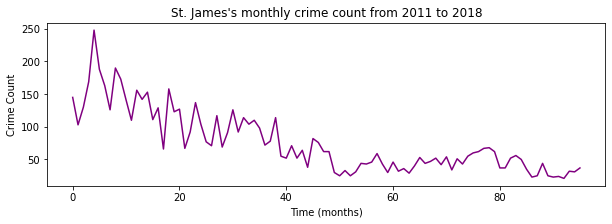

In [3]:
from pandas import read_csv
from matplotlib import pyplot
pyplot.rcParams['figure.figsize']=[10, 3]
# load dataset
series = read_csv('st_james.csv', header=0, index_col=0)
values = series.values
# plot dataset
pyplot.plot(values, color = 'purple')
pyplot.rcParams['figure.figsize']=[10, 3]
pyplot.title("St. James's monthly crime count from 2011 to 2018")
pyplot.xlabel('Time (months)')
pyplot.ylabel('Crime Count')
pyplot.show()

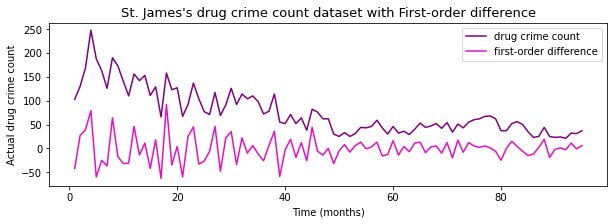

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
# First-order difference
series_new = series.reset_index()
series_new['count_diff'] = series_new['count'].diff(periods=1)
series_new = series_new.dropna()

# Plot
plt.title("St. James's drug crime count dataset with First-order difference", size=13)
plt.plot(series_new['count'], label='drug crime count', color='purple')
plt.plot(series_new['count_diff'], label='first-order difference', color='#E710C0')
plt.xlabel('Time (months)')
plt.ylabel('Actual drug crime count')
plt.legend();

In [5]:
series_new_values= series_new['count_diff'].values.reshape(-1, 1)
series_new_values.ndim

2

>expected=67.0, predicted=48.0
>expected=68.0, predicted=59.7
>expected=62.0, predicted=71.1
>expected=37.0, predicted=63.7
>expected=37.0, predicted=42.1
>expected=52.0, predicted=35.7
>expected=56.0, predicted=44.6
>expected=50.0, predicted=51.0
>expected=35.0, predicted=49.8
>expected=23.0, predicted=44.2
>expected=25.0, predicted=36.9
>expected=44.0, predicted=34.6
>expected=25.0, predicted=47.0
>expected=23.0, predicted=41.4
>expected=24.0, predicted=36.6
>expected=21.0, predicted=31.3
>expected=32.0, predicted=27.4
>expected=31.0, predicted=34.3
>expected=37.0, predicted=29.8
MSE: 195.569
RMSE: 13.985


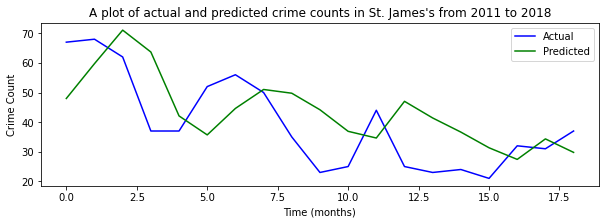

In [6]:
# forecast monthly crime count with random forest. Code adapted from https://machinelearningmastery.com/random-forest-for-time-series-forecasting/
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
        # transform list into array
        train = asarray(train)
        # split into input and output columns
        trainX, trainy = train[:, :-1], train[:, -1]
        model = RandomForestRegressor(n_estimators=500, min_samples_split=6, 
                                      max_depth=70, min_samples_leaf=3, max_features='auto',                                    
                                      random_state=0)
        model.fit(trainX, trainy)
       
        
        # make a one-step prediction
        yhat_j = model.predict([testX])
        return yhat_j[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
        predictions = list()
        # split dataset
        train, test = train_test_split(data, n_test)
        # seed history with training dataset
        history = [x for x in train]
        # step over each time-step in the test set
        for i in range(len(test)):
            # split test row into input and output columns
            testX, testy = test[i, :-1], test[i, -1]
            # fit model on history and make a prediction
            yhat_j = random_forest_forecast(history, testX)
            # store forecast in list of predictions
            predictions.append(yhat_j)
            # add actual observation to history for the next loop
            history.append(test[i])
            # summarize progress
            print('>expected=%.1f, predicted=%.1f' % (testy, yhat_j))
        # estimate prediction error
        error = mean_squared_error(test[:, -1], predictions)
        return error, test[:, -1], predictions

# load the dataset
series = read_csv("st_james.csv", header=0, index_col=0)
values = series.values#series_new_values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mse, y, yhat_j = walk_forward_validation(data, 19)
print('MSE: %.3f' % mse)
print('RMSE: %.3f' % float(format(np.sqrt(mse))))

# plot expected vs predicted
pyplot.plot(y, color='blue', label='Actual')
pyplot.plot(yhat_j, color='green', label='Predicted')
pyplot.xlabel('Time (months)')
pyplot.ylabel('Crime Count')
pyplot.legend()
pyplot.title("A plot of actual and predicted crime counts in St. James's from 2011 to 2018")
pyplot.show()

In [7]:
st_james_df = read_csv('st_james.csv')
st_james_df['count_pred'] = 0
st_james_df['count_pred'][77:] = yhat_j
st_james_df.tail()

,Year,count,count_pred
91,201808,24,36.632926
92,201809,21,31.337871
93,201810,32,27.411625
94,201811,31,34.337793
95,201812,37,29.778503


Text(0.5, 1.0, "Actual and predicted crime count in St. James's from 2011 to 2018")

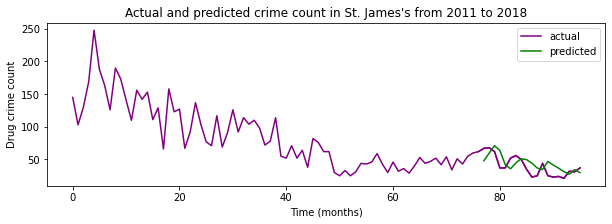

In [8]:
pyplot.plot(st_james_df['count'], color='purple')
pyplot.plot(st_james_df['count'][76:], color='purple', label='actual')
pyplot.plot(st_james_df['count_pred'][77:], color='green', label='predicted')
pyplot.legend()
pyplot.xlabel('Time (months)')
pyplot.ylabel('Drug crime count')
pyplot.title("Actual and predicted crime count in St. James's from 2011 to 2018")

-------------------------------------------------------------------------------------------------------------------------